# Introduction

The Long-Short Term Memory (LSTM) is the most commonly used deep learning technique for sequential data. As its name indicates, LSTM can learn long term relationships by using _memory cells_ and a bunch of control gates. Quote from [Colah's post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/): 

> LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

The idea sounds pretty cool, but does it really work as claimed? I'd like to use a simple example to check what exactly is being remembered or forgot, what the memory cells and gates do during prediction. We're going to hack into the Keras's implementation of LSTM and examine what's inside the blackbox. 

A common example people use to explain LSTM is the plurality, i.e., the model needs to remember the plurality of the subject to predict the correct plurality of the verb. So we can train a word-level LSTM to check how the plurality is remembered (also quoted from Colah's post): 

> For example, it might output whether the subject is singular or plural, so that we know what form a verb should be conjugated into if that’s what follows next.

However word-level models are more complicated than character-level models, it's not hard to do but I'd say the additional complication (embeddings, etc.) is totally irrelavant to what we want to study in here. Instead, I'm going to train a character-level model to generate XML text. 

The XML syntax doesn't allow nested tags, so `>` must be used to close a `<`. Also, `</...>` is used to close `<...>`. Clearly the model needs to remember things during text generation. 

## The dataset 

The training data set used here is the [patent grant](https://www.kaggle.com/uspto/patent-grant-full-text) data set from Kaggle. A subset (`data/patent_1M.txt`) is used for training, and I have removed the `<img>`, `<p>`, `<figure>`, `<othercit>` tags as their contents are too long, because our goal is not to generate a perfect patent grant XML, we can study the LSTM as long as the generated XML is valid in syntax and the content is not random. 

## The model

The model I used in here has two LSTM layers, we'll see the details soon. I have trained it for 40 epochs, and it works pretty well already. Let's load the trained model and see how it works: 

In [1]:
%matplotlib inline

import keras.backend as K
import numpy as np

from char_level_rnn import CharLevelRNN
from utils import *

Using TensorFlow backend.


In [2]:
rnn = CharLevelRNN('models/patent_1M_40.h5')
rnn.load_trainset('data/patent_1M.pkl')

Load model from: models/patent_1M_40.h5


`CharLevelRNN` is a simple class for building character-level LSTM models, using Keras. Let's see what the model looks like:

In [3]:
rnn.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 53)            0         
_________________________________________________________________
lstm_1 (LSTM)                [(None, 20, 128), (None,  93184     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                [(None, 128), (None, 128) 131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 53)                6837      
_________________________________________________________________
activation_1 (Activation)    (None, 53)                0         
Total para

In total we have 53 unique characters in our train set data. The input contains 20 characters, each is represented by a vector with length 53. The 20 characters are fed into the first LSTM layer, which has 128 hidden units and returns a sequence of 20 vectors. After a dropout layer, it's fed into a second LSTM layer, which also has 128 hidden units and returns a single vector. After another dropout layer, it's fed into a fully connected layer and the dimension becomes 53, after a softmax activation, we get the probability vector as the final output. Then we can generate the next character using this probability distribution. 

Let's generate a sequence starting from `<us-citation>`: 

In [4]:
seed = 120
np.random.seed(seed)
print(rnn.generate_text('<us-citation>'))

<us-citation>
<patcit num="00095">
<document-id>
<country>us</country><main-classification>d 7662-317</main-classification>
</classification-national>
</us-citation>
<us-citation>
<patcit num="00021">
<document-id>
<country>us</country>
<doc-number>d764346</doc-number>
<kind>s</kind>
<name>janrher</name>
<date>2


Not bad! Now we're ready to explore what's inside the magic box. 

## 

We're interested in the hidden states, the memory cells and the gates. In Keras, a LSTM layer will return the hidden states and the memory cells together with the output if you set `return_state` to true. Then we can setup a `Function` to get the inputs and outputs:

In [5]:
lstm1 = rnn.model.layers[1]
lstm1_output_f = K.function(rnn.model.inputs, lstm1.get_output_at(0)) 
lstm2 = rnn.model.layers[3]
lstm2_input_f = K.function(rnn.model.inputs, [lstm2.get_input_at(0)]) 
lstm2_output_f = K.function(rnn.model.inputs, lstm2.get_output_at(0)) 

Later when we feed inputs to the `Function`'s and run them, we can get the layer outputs. It's same as running a TensorFlow session with `feed_dict` to get the operation outputs. 

Now we generate a XML sequence character by character, and save all intermediate results:

In [6]:
lstm1_input = []
lstm1_output = []
lstm2_input = []
lstm2_output = []
starter = '<us-citation>'
seq = starter.lower().rjust(rnn.X_LEN, '@')
result = starter

In [7]:
np.random.seed(seed)
N = 300
for _ in range(N):
    X = np.zeros((1, rnn.X_LEN, rnn.n_char))
    for t, char in enumerate(seq):  
        if char != '@':
            X[0, t, rnn.char_index[char]] = 1.     
    lstm1_input.append(X)
    lstm1_output.append(lstm1_output_f([X]))
    lstm2_input.append(lstm2_input_f([X]))        
    lstm2_output.append(lstm2_output_f([X]))
    
    prediction = rnn.model.predict(X, verbose=0)[0]
    next_index = rnn._sample(prediction, temperature = 1.0)
    next_char = rnn.index_char[next_index]
    
    result += next_char
    seq = seq[1:] + next_char

print(result)

<us-citation>
<patcit num="00095">
<document-id>
<country>us</country><main-classification>d 7662-317</main-classification>
</classification-national>
</us-citation>
<us-citation>
<patcit num="00021">
<document-id>
<country>us</country>
<doc-number>d764346</doc-number>
<kind>s</kind>
<name>janrher</name>
<date>2


Now we have got all the hidden states and memory cells of the two LSTM layers for the 300 time steps. We can choose one memory cell and plot its changes (change from previous step, absolute value): 

In [8]:
lstm1_a = np.array([v[0][0,-1,:] for v in lstm1_output]).T
lstm1_c = np.array([v[2][0,:] for v in lstm1_output]).T
lstm2_a = np.array([v[0][0,:] for v in lstm2_output]).T
lstm2_c = np.array([v[2][0,:] for v in lstm2_output]).T

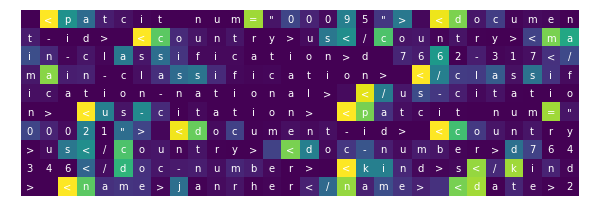

In [9]:
plot_x = np.tanh(lstm2_c[112,:])
plot_x[1:] = np.abs(plot_x[1:] - plot_x[:-1])
plot_x[0] = 0
plot_text_with_color(plot_x, result[-N:])

This is the generated 300 characters, reads from left to right, the color indicates the amount of change: smallest is in deep blue, largest is in bright yellow. 

Well, there might be some patterns, but we need to think about what we're plotting. `lstm1_c` contains the 300 memory cell vectors, if we don't think about it carefully and dig into Keras's implementation, we may think that the memory cell of one time step is fed to the next time step as the initial cell state. But that's wrong! Actually, for each step in the for-loop (300 steps in total), the memory cell state will always be reset to zeros! 

This is how it works during prediction: in each step of the 300-step-for-loop, an input sequence of 20 characters is fed into the first LSTM layer. This layer will initialize the hidden state ($a_0$) and memory cell ($c_0$), then take the first input character ($x_1$), get the new hidden state ($a_1$) and memory cell ($c_1$), then take the second character ($x_2$) together with $a_1$ and $c_1$ to calculate $a_2$ and $c_2$, and so on. The second LSTM layer works in the same way (its input is the output of the first dropout layer, a sequence of length 20). 

In the next step of the 300-step-for-loop, a new input sequence of 20 characters is used. Although this sequence is same as the input sequence in the last step (only one character is different), the $a_0$ and $c_0$ of the LSTM layers are reset to zero and have nothing to do with the $a_20$ and $c_20$ from previous step. So we can say the LSTM's memory is reset in each step. 

Of course, since the input sequence in each step of the 300-step-for-loop is so similar, the output memory cells should have some relationship, but it's not clear how to make sense out of it. 

## 

Instead of looking at the step results of the 300-step-for-loop, we focus on one step only. In a single step, for each LSTM, Keras has a 20-step-for-loop internally (our input length is 20). The source code for this loop (a while-loop actually) is in the `rnn` function of the `backend/tensorflow_backend.py`. And in each step of the 20-step-for-loop, we do: 

$$ig^{\langle t \rangle} = \sigma\left(W_u\begin{bmatrix} a^{\langle t-1 \rangle} \\ x^{\langle t \rangle}\end{bmatrix} + b_u \right)\tag{1}$$
$$fg^{\langle t \rangle} = \sigma\left(W_f\begin{bmatrix} a^{\langle t-1 \rangle} \\ x^{\langle t \rangle}\end{bmatrix} + b_f \right)\tag{2}$$
$$og^{\langle t \rangle} = \sigma\left(W_o\begin{bmatrix} a^{\langle t-1 \rangle} \\ x^{\langle t \rangle}\end{bmatrix} + b_o \right)\tag{3}$$

$$c^{\langle t \rangle} = fg^{\langle t \rangle} * c^{\langle t-1 \rangle} + ig^{\langle t \rangle} * \tanh\left(W_c\begin{bmatrix} a^{\langle t-1 \rangle} \\ x^{\langle t \rangle}\end{bmatrix} + b_c \right) \tag{4}$$
$$a^{\langle t \rangle} = og^{\langle t \rangle} * \tanh\left(c^{\langle t \rangle}\right)\tag{5}$$

Where $ig^{\langle t \rangle}$ is the update gate, $fg^{\langle t \rangle}$ is the forget gate.  If $ig^{\langle t \rangle} = 0$ and $fg^{\langle t \rangle} = 1$, then the new memory cell equals to the previous memory cell; If $ig^{\langle t \rangle} = 1$ and $fg^{\langle t \rangle} = 0$, then the previous memory cell will be completely forgotten. 
$og^{\langle t \rangle}$ is the output gate, this gate multiplies by the memory cell gives the new hidden state. To make the gate name convention consistent with Keras source code (where `i`, `f`, `o`, `c` are used for update gate, forget gate, output gate, memory cell. Refer to the `LSTMCell` class), I used $ig$, $fg$, $og$ for the update gate, forget gate, output gate. 

Keras only support access to the hidden states and final memory cells, the intermediate memory cell states and all the gates are not accessible. In most cases, they are technical details, users won't need to know about them. But in here, we'd like to check the cells and gates values, so we need to break into Keras's `LSTMCell` class and calculate by ourselves. My function `run_lstm` takes part of the Keras source code and calculates all of these intermediate results. 

To make sure my calcuation is correct, I run my `run_lstm` at a certain time step ($t$ is any integer from 0 to 399) to get the final hidden states and memory cell states, and compare that with Keras's output (`lstm1_a`, `lstm1_c`, etc):

In [10]:
t = 3
inputs = K.variable(lstm1_input[t][0])
aa, cc = run_lstm(lstm1.cell, inputs, 
                  lstm1.get_initial_state(K.expand_dims(inputs, 0)))
(K.eval(aa) - lstm1_a[:, t]).sum()

0.0

They matched exactly! So I can trust the `run_lstm` function. Now I'd like to pick up a $t$ to focus on, because I don't have time to play with all 300 time steps. I take $t=274$, where the input string is:

In [11]:
''.join([rnn.index_char[i] for i in np.where(lstm1_input[274][0] == 1)[1]])

'r>\n<kind>s</kind>\n<n'

This input is pretty good because it contains two `<...>` and one `<...>...</...>`, we can see how the memory cells change when they read through this sequence. Now run `run_lstm` to get values for $ig$, $fg$, $og$, $a$ and $c$, at the 20 time steps. We first look at the first LSTM layer: 

In [12]:
t = 274
inputs = K.variable(lstm1_input[t][0])
step_results = run_lstm(lstm1.cell, inputs, 
                        lstm1.get_initial_state(K.expand_dims(inputs, 0)),
                        return_all=True)

Now we look at the forget gates first:

In [13]:
forget_gates = np.array([K.eval(fg) for _,fg,_,_,_ in step_results]).squeeze()

Let's plot it with the 20-character sequence as Y axis and the 128 memory cells as X axis. The color code uses dark blue for smallest value and bright yellow for largest. 

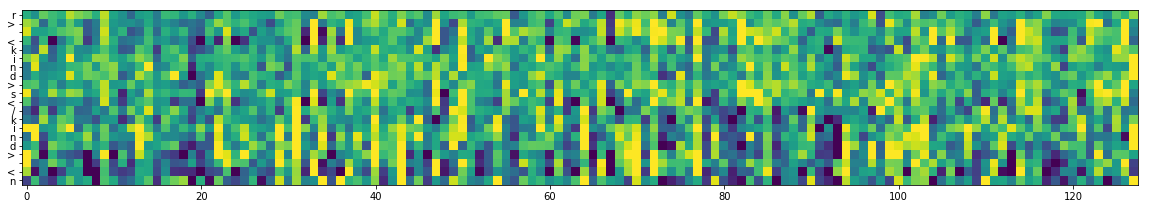

In [14]:
_, ax = plt.subplots(figsize=forget_gates.shape)
ax.imshow(forget_gates)
_ = plt.yticks(list(range(20)), 'r>\n<kind>s</kind>\n<n')
plt.show()

We're interested in memory cells that are responsive to the angle brackets. I chose some memory cells here for further check:

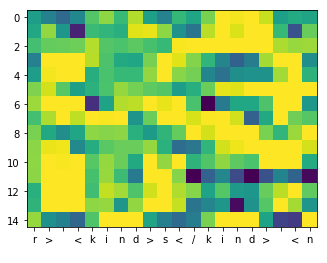

In [15]:
_, ax = plt.subplots()
ax.imshow(forget_gates[:,[13,22,31,33,37,43,47,50,64,70,72,82,114,126,127]].T)
_ = plt.xticks(list(range(20)), 'r>\n<kind>s</kind>\n<n')
plt.show()

From Eq. (4) we know if the value of $fg$ is close to zero (dark blue), the memory cell tends to forget the previous state, while if the value of $fg$ is close to one (bright yellow), it tends to remember the previous state. So a bright yellow block means the forget gate tries to let the memory cell remember the state for a while. Look at the rows, some cells do seem to remember different things for the XML syntax. 

Now what about the memory cell values? We do the same thing for visualization:

In [16]:
cells = np.array([K.eval(cc) for _,_,cc,_,_ in step_results]).squeeze()

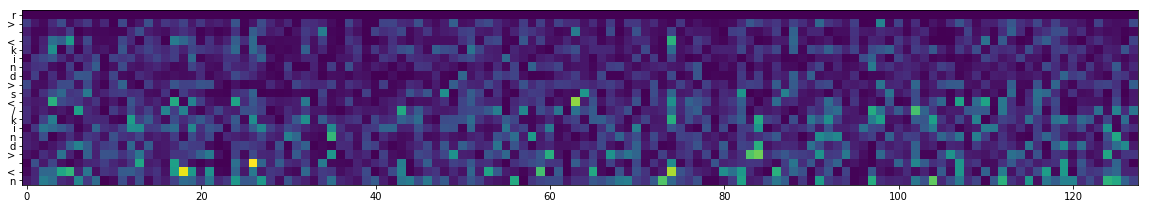

In [17]:
diff = np.zeros(cells.shape)
diff[1:,:] = cells[1:,:] - cells[:-1,:]
_, ax = plt.subplots(figsize=diff.shape)
ax.imshow(np.abs(diff))
_ = plt.yticks(list(range(20)), 'r>\n<kind>s</kind>\n<n')
plt.show()

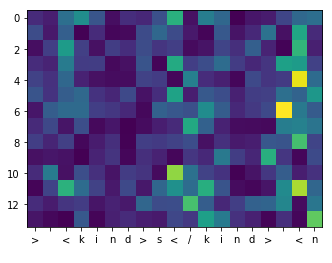

In [18]:
_, ax = plt.subplots()
ax.imshow(np.abs(diff[1:,[3,4,5,17,18,24,26,43,59,60,63,74,102,104]].T))
_ = plt.xticks(list(range(19)), '>\n<kind>s</kind>\n<n')
plt.show()

In above I plotted the absolute change in memory cells against the previous ones. We can see some sharp changes near the angle brackets. 

What about the second LSTM layer? Let's try the same thing. First we double check our calculation matches Keras's: 

In [19]:
t = 3
inputs = K.variable(lstm2_input[t][0].squeeze())
aa, cc = run_lstm(lstm2.cell, inputs, 
                  lstm2.get_initial_state(K.expand_dims(inputs, 0)))
(K.eval(aa) - lstm2_a[:, t]).sum()

0.0

Good, our correctness is confirmed again. Now let's plot the forget gates:

In [20]:
t = 274
inputs = K.variable(lstm2_input[t][0].squeeze())
step_results_lstm2 = run_lstm(lstm2.cell, inputs, 
                              lstm2.get_initial_state(K.expand_dims(inputs, 0)),
                              return_all=True)

In [21]:
fg_lstm2 = np.array([K.eval(fg) for _,fg,_,_,_ in step_results_lstm2]).squeeze()

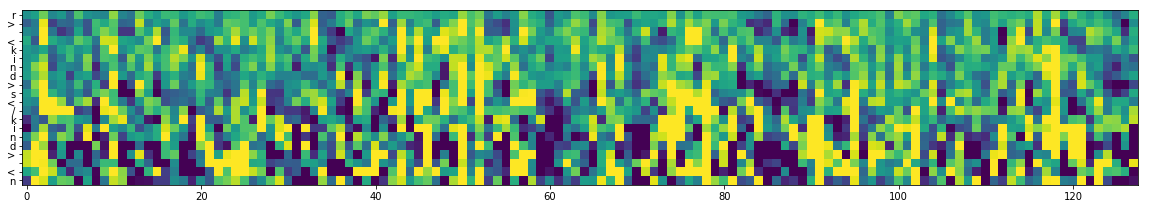

In [22]:
_, ax = plt.subplots(figsize=fg_lstm2.shape)
ax.imshow(fg_lstm2)
_ = plt.yticks(list(range(20)), 'r>\n<kind>s</kind>\n<n')
plt.show()

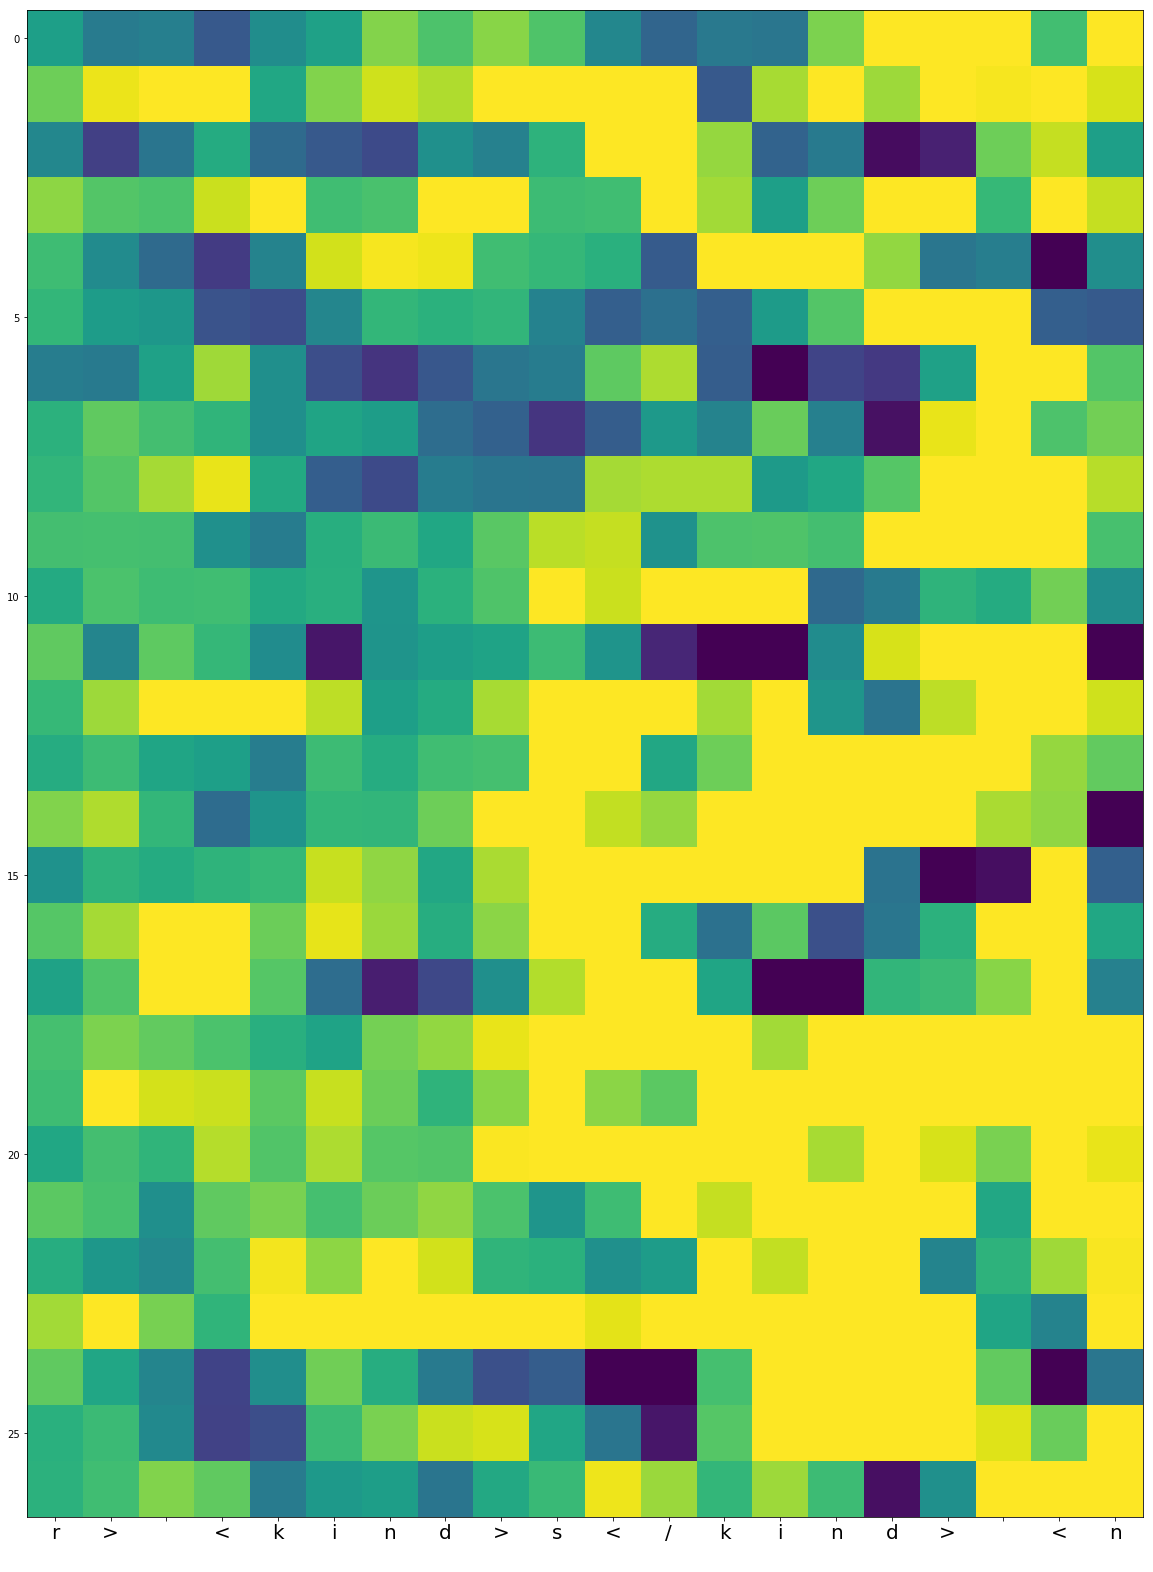

In [23]:
_, ax = plt.subplots(figsize=fg_lstm2.shape)
ax.imshow(fg_lstm2[:,[1,2,3,10,20,21,22,23,24,25,27,40,43,46,74,75,76,77,78,91,95,102,117,118,120,121,123]].T)
_ = plt.xticks(list(range(20)), 'r>\n<kind>s</kind>\n<n', fontsize=20)
plt.show()

We saw some similar patterns: streaks of bright yellow blocks near angle brackets, which means the forget gate asks the memory cell to keep remembering the previous state. 

Now we look at the memory cell state changes: 

In [24]:
c_lstm2 = np.array([K.eval(cc) for _,_,cc,_,_ in step_results_lstm2]).squeeze()

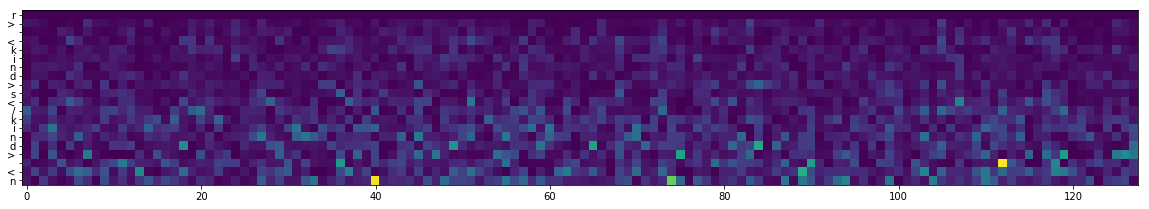

In [25]:
diff_lstm2 = np.zeros(c_lstm2.shape)
diff_lstm2[1:,:] = c_lstm2[1:,:] - c_lstm2[:-1,:]
_, ax = plt.subplots(figsize=diff_lstm2.shape)
ax.imshow(np.abs(diff_lstm2))
_ = plt.yticks(list(range(20)), 'r>\n<kind>s</kind>\n<n')
plt.show()

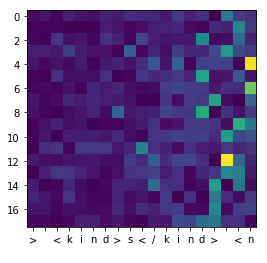

In [26]:
_, ax = plt.subplots()
ax.imshow(np.abs(diff_lstm2[1:,[11,13,18,36,40,65,74,75,84,89,90,107,112,118,119,125,126,127]].T))
_ = plt.xticks(list(range(19)), '>\n<kind>s</kind>\n<n')
plt.show()

We observe some sharp changes around the angle brackets as well. Although it's not clear what role each neuron plays in the prediction, but consistent patterns can be seen for a given neuron. For example, let's say the 107's neuron in the second LSTM layer is very responsive to `<`, then that's what this neuron learned during training and it's written in the model, so if we change a starter string and do a prediction again, this neuron will have the same behavior. 

## Conclusion

To study how the memory works in the Long-Short Term memory networks, we trained a LSTM network to generate patent documents in XML format. I chose a XML dataset because the XML syntax has long term dependencies and a simple character-level model is sufficient for this task. We then extracted and checked the memory cell and gate values in this step, how it changes during character generation. We observed some patterns, it tells us how the gates controls the memory cells and what the cells try to remember. 

It's very hard to interpret what a neural network learns and how it works. We can see some patterns, like the visualization of a Convolutional Neural Network, but it's not a rigorous story and we haven't yet fully understood how neural networks are able to do all kinds of impressive jobs. Same thing here, we looked into the LSTM's internal states, but it's still not clear how exactly it manages to learn the XML syntax. 

The good thing is now LSTM is no longer a blackbox to us, we have hacked into its Keras implementation and got everything we want. If you use some other frameworks, it'll be similar I guess. Now you can use what we have here to create more visualizations and find better ways to demonstrate what's been memorized. 